# CDP Competition Starter Notebook
Example data mapping, EDA and data wrangling pipeline to relate CDP Corporate response data to CDP Cities data and external data sets containing social equity data.

#### Parameters

#### Input

**CDP Corporate Questionnaire response data sets**
- **2019_Full_Climate_Change_Dataset.csv** = 2019 Climate Change publically disclosed questionnaire responses for North America
- **2019_Full_Water_Security_Dataset.csv** = 2019 Water Security publically disclosed questionnaire responses for North America

**CDP Cities Questionnaire response data sets**
- **2020_-_Full_Cities_Dataset.csv** = Full 2020 Cities Questionnaire response data set

**CDP Cities Meta data sets**
- **NA_HQ_public_data.csv** = CDP curated Organisations metadata, mapping publically disclosed North American organisations to HQ city and state

**External Non-CDP data sets**
- **SVI2018_US.csv** = US Centers for Disease Control and Prevention (CDC) Social Vulnerability Index (SVI) Data for 2018 (*Census tract level*) - available publicly  bat https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html
- **SVI2018_US_COUNTY.csv** = US Centers for Disease Control and Prevention (CDC) Social Vulnerability Index (SVI) Data for 2018 (*County level*) - available publicly at https://www.atsdr.cdc.gov/placeandhealth/svi/data_documentation_download.html
- **uscities.csv** = metadata for United States cities and towns, with information such as populations size, median age and lat,lng location coordinates - available publicly at https://simplemaps.com/data/us-cities.

SVI 2018 Documentation and Data Dictionary https://www.atsdr.cdc.gov/placeandhealth/svi/documentation/SVI_documentation_2018.html

#### Output

EDA and Visualisations to begin investigating the CDP competition data sets, environmental performance indicators and social-equity KPIs.


## Imports

In [1]:
# standard libs
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json

# plotting libs
import seaborn as sns

# geospatial libs
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Polygon
import geopandas as gpd
import folium
import plotly.graph_objects as go
import plotly_express as px

# set in line plotly 
from plotly.offline import init_notebook_mode;
init_notebook_mode(connected=True)

print(os.getcwd())

/kaggle/working


## Data

### Import Data

In [2]:
# import corporate response data
cc_df = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Climate Change/2019_Full_Climate_Change_Dataset.csv')
ws_df = pd.read_csv('../input/cdp-unlocking-climate-solutions/Corporations/Corporations Responses/Water Security/2019_Full_Water_Security_Dataset.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning:

Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.



In [3]:
# import cities response df
cities_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Cities/Cities Responses/2020_Full_Cities_Dataset.csv")

In [4]:
# external data - import CDC social vulnerability index data - census tract level
svi_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Supplementary Data/CDC Social Vulnerability Index 2018/SVI2018_US.csv")

In [5]:
# cities metadata - lat,lon locations for US cities
cities_meta_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Supplementary Data/Simple Maps US Cities Data/uscities.csv")

# cities metadata - CDP metadata on organisation HQ cities
cities_cdpmeta_df = pd.read_csv("../input/cdp-unlocking-climate-solutions/Supplementary Data/Locations of Corporations/NA_HQ_public_data.csv")

### Helpers

In [6]:
def list_dedupe(x):
    """
    Convert list to dict and back to list to dedupe
    
    Parameters
    ----------
    x: list
        Python list object
        
    Returns
    -------
    dictionary:
        dictionary object with duplicates removed
        
    """
    return list(dict.fromkeys(x))

### Set up and Parameters

## Calculations

### Data Cleaning & EDA

#### Extract City Questionnaire Response and map Cities to Organisations

- Extract city response data for question *6.2 Does your city collaborate in partnership with businesses in your city on sustainability projects?*
- Map cities to organisations who are headquartered within that city, using the NA_HQ_public_data.csv meta data file

(see [CDP Cities questionnaire guidance](https://guidance.cdp.net/en/guidance?cid=16&ctype=theme&idtype=ThemeID&incchild=1&microsite=0&otype=Questionnaire&tags=TAG-637%2CTAG-570%2CTAG-13013%2CTAG-13002%2CTAG-13009%2CTAG-13010))


In [7]:
cities_6_2 = cities_df[cities_df['Question Number'] == '6.2']\
    .rename(columns={'Organization': 'City'})

cities_6_2['Response Answer'] = cities_6_2['Response Answer'].fillna('No Response')

cities_6_2.head()

,Questionnaire,Year Reported to CDP,Account Number,City,Country,CDP Region,Parent Section,Section,Question Number,Question Name,Column Number,Column Name,Row Number,Row Name,Response Answer,Comments,File Name,Last update
2093,Cities 2020,2020,54538,Bath and North East Somerset,United Kingdom of Great Britain and Northern I...,Europe,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2107,Cities 2020,2020,42120,City of Salvador,Brazil,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2112,Cities 2020,2020,826210,Junta Intermunicipal de Medio Ambiente de la C...,Mexico,Latin America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
2594,Cities 2020,2020,37241,City of Berkeley,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM
3561,Cities 2020,2020,50549,City of Fort Worth,United States of America,North America,Opportunities,Collaboration,6.2,Does your city collaborate in partnership with...,0,NaN,0,NaN,Yes,NaN,NaN,09/07/2020 09:45:36 AM


Clean Organisation City HQ Metadata

In [8]:
# state abbreviation dictionary
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# map dict to clean full state names to abbreviations
cities_cdpmeta_df['state'] = cities_cdpmeta_df['address_state'].map(us_state_abbrev)

# infill non-matched from dict
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].fillna(cities_cdpmeta_df['address_state'])
cities_cdpmeta_df['state'] = cities_cdpmeta_df['state'].replace({'ALBERTA':'AB'})
cities_cdpmeta_df['address_city'] = cities_cdpmeta_df['address_city'].replace({'CALGARY':'Calgary'})
cities_cdpmeta_df= cities_cdpmeta_df.drop(columns=['address_state'])

# create joint city state variable
cities_cdpmeta_df['city_state'] = cities_cdpmeta_df['address_city'].str.cat(cities_cdpmeta_df['state'],sep=", ")

cities_cdpmeta_df

,account_number,organization,public,invitation_status,request_status,theme,survey_year,survey_name,hq_country,address_city,address_lat,adress_long,state,city_state
0,58859,Hewlett Packard Enterprise Company,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,United States of America,San Jose,NaN,NaN,CA,"San Jose, CA"
1,31831,Bausch Health Cos. Inc.,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,Canada,Rochester,NaN,NaN,NY,"Rochester, NY"
2,40952,BWI Group,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,China,NaN,NaN,NaN,NaN,NaN
3,30634,Guangdong Textiles,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,China,NaN,NaN,NaN,NaN,NaN
4,19582,Johnson Controls International PLC,public,Submitted,Submitted,Climate Change,2020,Climate Change 2020,Ireland,Cork,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3294,38267,"American Cleaning Supply, Inc.",public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,NaN,NaN,NaN,NaN,NaN
3295,848018,CANACOL ENERGY LTD.,public,Submitted,Submitted,Water,2020,Water Security 2020,Canada,Calgary,NaN,NaN,AB,"Calgary, AB"
3296,61423,AlmadenÂ Press,public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,NaN,NaN,NaN,NaN,NaN
3297,847168,Raytheon Technologies Corporation,public,Submitted,Submitted,Water,2020,Water Security 2020,United States of America,Waltham,NaN,NaN,MA,"Waltham, MA"


Summarise the cities metadata to count the number organisations (HQ) per city 

In [9]:
cities_count = cities_cdpmeta_df[['organization', 'address_city', 'state', 'city_state']]\
        .groupby(['address_city', 'state', 'city_state']).count().\
            sort_values(by = ['organization'],ascending = False)\
                .reset_index()\
                    .rename(columns={'organization' : 'num_orgs'})
cities_count.head()

,address_city,state,city_state,num_orgs
0,New York,NY,"New York, NY",138
1,Calgary,AB,"Calgary, AB",94
2,Toronto,ON,"Toronto, ON",85
3,San Jose,CA,"San Jose, CA",54
4,Chicago,IL,"Chicago, IL",45


City name conversion

- Align City names in CDP City questionnaire response data ('City Org') with common city names that may be present in external data sets
- e.g. 'City of Boulder' -> Boulder

*Note* This data quality control step can also be addressed by using the 'City' column in the 2019_Cities_Disclosing_to_CDP.csv dataset

In [10]:
# convert indexes to columns'
cities_count.reset_index(inplace=True)
cities_count = cities_count.rename(columns = {'index':'city_id'})
cities_df.reset_index(inplace=True)
cities_df = cities_df.rename(columns = {'index':'city_org_id'})

# convert id and city label columns into lists
city_id_no = list_dedupe(cities_count['city_id'].tolist())
city_name = list_dedupe(cities_count['address_city'].tolist())

city_org_id_no = list_dedupe(cities_df['city_org_id'].tolist())
city_org_name = list_dedupe(cities_df['Organization'].tolist())

# remove added index column in cities df
cities_df.drop('city_org_id', inplace=True, axis=1)
cities_count.drop('city_id', inplace=True, axis=1)

# zip to join the lists and dict function to convert into dicts
city_dict = dict(zip(city_id_no, city_name))
city_org_dict = dict(zip(city_org_id_no, city_org_name))

In [11]:
# compare dicts - matching when city name appears as a substring in the full city org name
city_names_df = pd.DataFrame(columns=['City ID No.','address_city', 'City Org ID No.','City Org', 'Match']) # initiate empty df

for ID, seq1 in city_dict.items():
    for ID2, seq2 in city_org_dict.items():
        m = re.search(seq1, seq2) # match string with regex search 
        if m:
            match = m.group()
            # Append rows in Empty Dataframe by adding dictionaries 
            city_names_df = city_names_df.append({'City ID No.': ID, 'address_city': seq1, 'City Org ID No.': ID2, 'City Org': seq2, 'Match' : match}, ignore_index=True)
            
# subset for city to city org name matches
city_names_df = city_names_df.loc[:,['address_city','City Org']]

city_names_df.head()

,address_city,City Org
0,New York,New York City
1,Calgary,City of Calgary
2,Toronto,City of Toronto
3,Chicago,City of Chicago
4,Houston,City of Houston


Join city_org names to city-org count table


In [12]:
cities_count  = pd.merge(cities_count, city_names_df, on='address_city', how='left')
cities_count.head()

,address_city,state,city_state,num_orgs,City Org
0,New York,NY,"New York, NY",138,New York City
1,Calgary,AB,"Calgary, AB",94,City of Calgary
2,Toronto,ON,"Toronto, ON",85,City of Toronto
3,San Jose,CA,"San Jose, CA",54,NaN
4,Chicago,IL,"Chicago, IL",45,City of Chicago


Join Count of Disclosing Organisations in HQ Cities with Question 6.2 Response dataframe

- Label the response variable as a city's current Sustainability Project Collaboration

In [13]:
cities_6_2 = cities_6_2[['City', 'Response Answer']].rename(columns={'City' : 'City Org'})
cities_count = pd.merge(left=cities_count, right=cities_6_2, how='left', 
                        on ='City Org').rename(columns={'Response Answer' : 'Sustainability Project Collab.'})

cities_count['Sustainability Project Collab.'] = cities_count['Sustainability Project Collab.'].fillna('No Response')

Plot cities containing the highest proportion of organisations disclosing to CDP

- Highlight number of disclosing orgnanisations with a HQ in the city
- Highlight the city's response to question 6.2 as bar colour


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text major ticklabel objects>)

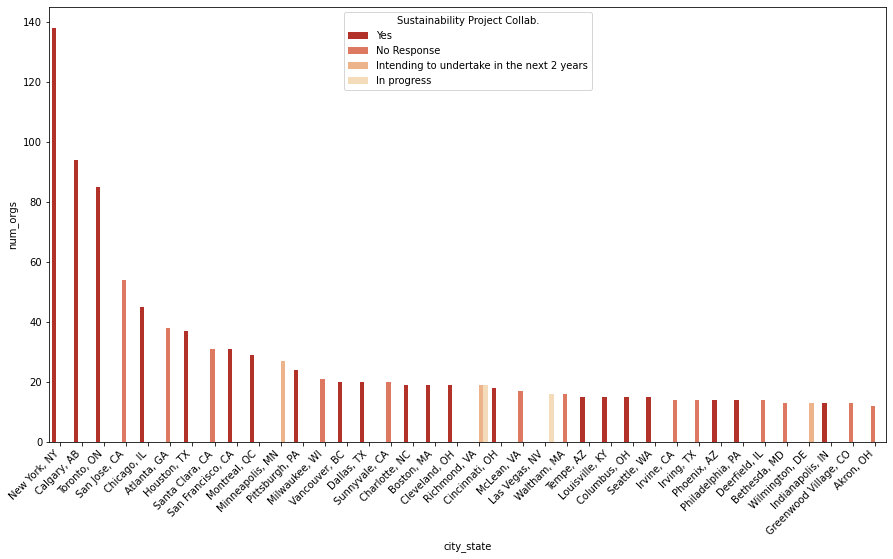

In [14]:
cities_count_50 = cities_count.iloc[0:40,:]

plt.figure(figsize=(15,8))
ax = sns.barplot(
    x="city_state", y="num_orgs",
    hue = "Sustainability Project Collab.",
    data=cities_count_50 ,
    palette="OrRd_r"
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'  
)


Spatial plot of cities and organisation mapping

[Example bubble map with plotting with plotly](https://plotly.com/python/bubble-maps/)

In [15]:
# subset for lat, lng cities data
cities_meta_df = cities_meta_df[['city', 'state_id', 'lat','lng']].rename(columns={'city' : 'address_city', 'state_id' : 'state'})
cities_meta_df.head()

,address_city,state,lat,lng
0,New York,NY,40.6943,-73.9249
1,Los Angeles,CA,34.1139,-118.4068
2,Chicago,IL,41.8373,-87.6862
3,Miami,FL,25.7839,-80.2102
4,Dallas,TX,32.7936,-96.7662


In [16]:
# join coordinates to cities count
cities_count = pd.merge(left=cities_count, right=cities_meta_df, how='left', on=['address_city', 'state'])

# convert text response to question 6.2 to an integar encoding 
resp_int_df = cities_count[["Sustainability Project Collab."]]
resp_int_df= resp_int_df.rename(columns={'Sustainability Project Collab.' : 'resp_int'})

labels = resp_int_df['resp_int'].unique().tolist()
mapping = dict( zip(labels,range(len(labels))) )
resp_int_df.replace({'resp_int': mapping},inplace=True)

resp_list = resp_int_df['resp_int'].tolist()
cities_count['resp_int'] = resp_list 
cities_count.head()

,address_city,state,city_state,num_orgs,City Org,Sustainability Project Collab.,lat,lng,resp_int
0,New York,NY,"New York, NY",138,New York City,Yes,40.6943,-73.9249,0
1,Calgary,AB,"Calgary, AB",94,City of Calgary,Yes,NaN,NaN,0
2,Toronto,ON,"Toronto, ON",85,City of Toronto,Yes,NaN,NaN,0
3,San Jose,CA,"San Jose, CA",54,NaN,No Response,37.3019,-121.8486,1
4,Chicago,IL,"Chicago, IL",45,City of Chicago,Yes,41.8373,-87.6862,0


- Highlight number of disclosing orgnanisations with a HQ in the city via bubble size
- Highlight city's response to question 6.2 as bubble colour and highlight in hover box

In [17]:
# plot spatial bubble map
cities_count['text'] = cities_count['address_city'] + '<br>Number of Orgs: ' + (cities_count['num_orgs']).astype(str) +\
    '<br>Sustainability Project Colloboration: ' + (cities_count['Sustainability Project Collab.']).astype(str)
limits = [(0,20),(21,40),(41,60),(61,80),(81,100)]
cities = []
scale = 5

fig = go.Figure()

for i in range(len(limits)):
    lim = limits[i]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = cities_count['lng'],
        lat = cities_count['lat'],
        text = cities_count['text'],
        marker = dict(
            size = cities_count['num_orgs']*scale,
            color = cities_count['resp_int'],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.update_layout(
        title_text = '2019 CDP Climate Change Corporate Responders (Public) by City',
        showlegend = False,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

####  Build NYC City Specific Dataset

Combine SVI dataset with CDP City Questionnaire and Organisation level 2019 Climate Change questionnaire response data

E.g. :
- Identify which organisations located within NYC see climate-related opportunities within their operations
- Match organisations with areas of the city that suffer from high unemployment rates
- Pinpoint areas of NYC that present an opportunity for corporate collobaration and therefore an uplift in social equity metrics

Subset climate change questionnaire response data for question C2.4a

*C2.4a Provide details of opportunities identified with the potential to have a substantive financial or strategic impact on your business.*

(see [CDP Climate Change questionnaire guidance](https://guidance.cdp.net/en/guidance?cid=13&ctype=theme&idtype=ThemeID&incchild=1&microsite=0&otype=Questionnaire&tags=TAG-646%2CTAG-605%2CTAG-600))

In [18]:
cc_2_4a = cc_df[cc_df['question_number'] == 'C2.4a']

Join 2019 corporate responses with organisation HQ metadata, matching climate change questionnaire organisations to their HQ city



In [19]:
cities_cdpmeta_join = cities_cdpmeta_df[["account_number", 'survey_year', 'address_city']]
cc_2_4a = pd.merge(left=cc_2_4a, right=cities_cdpmeta_join,  left_on=['account_number','survey_year'], right_on = ['account_number','survey_year'])

Subset for NYC HQ Cities


In [20]:
cc_nyc = cc_2_4a[(cc_2_4a['address_city'] =='New York')]

Join City Linked C2.4a response data to citys question 6.2 response data frame, matching NYC city level responses to NYC organisation level climate change questionnaire responses


In [21]:
cities_6_2['City Org'] = cities_6_2['City Org'].replace({'New York City':'New York'})
cc_nyc = pd.merge(left=cc_nyc, right= cities_6_2,  left_on=['address_city'], right_on = ['City Org']).rename(columns={'Response Answer' : 'sustain_collab'})
cc_nyc.head()

,account_number,organization,survey_year,response_received_date,accounting_period_to,ors_response_id,submission_date,page_name,module_name,question_number,...,table_columns_unique_reference,row_number,row_name,data_point_name,data_point_id,response_value,comments,address_city,City Org,sustain_collab
0,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c5-Type of financial impact,3,NaN,C2.4a_C5_Provide details of opportunities iden...,7562.0,"Other, please specify: Energy efficiency and r...",NaN,New York,New York,Yes
1,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c5-Type of financial impact,3,NaN,C2.4a_C5_Provide details of opportunities iden...,7562.0,"Other, please specify: Energy efficiency and r...",NaN,New York,New York,Yes
2,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c7-Time horizon,2,NaN,C2.4a_C7_Provide details of opportunities iden...,7564.0,Current,NaN,New York,New York,Yes
3,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c7-Time horizon,2,NaN,C2.4a_C7_Provide details of opportunities iden...,7564.0,Current,NaN,New York,New York,Yes
4,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,C2.4a_c15-Strategy to realize opportunity,2,NaN,C2.4a_C15_Provide details of opportunities ide...,7569.0,Colgate subsidiaries engage with our consumers...,NaN,New York,New York,Yes


Subset SVI data for NYC Counties from Federal Information Processing Standard (FIPS) codes

* The Bronx is Bronx County (ANSI / FIPS 36005)
* Brooklyn is Kings County (ANSI / FIPS 36047)
* Manhattan is New York County (ANSI / FIPS 36061)
* Queens is Queens County (ANSI / FIPS 36081)
* Staten Island is Richmond County (ANSI / FIPS 36085)

(source: https://guides.newman.baruch.cuny.edu/nyc_data)

In [22]:
nyc_svi_df = svi_df[svi_df['STCNTY'].isin([36005, 36047, 36061, 36081, 36085])]
nyc_svi_df['City'] = 'New York'
print(nyc_svi_df.shape)
nyc_svi_df.head()

(2166, 125)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,ST,STATE,ST_ABBR,STCNTY,COUNTY,FIPS,LOCATION,AREA_SQMI,E_TOTPOP,M_TOTPOP,...,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP,City
338,36,NEW YORK,NY,36005,Bronx,36005000100,"Census Tract 1, Bronx County, New York",0.647574,7080,290,...,-999,1,-999,-999,0,17,-999.0,-999.0,15770,New York
339,36,NEW YORK,NY,36005,Bronx,36005011000,"Census Tract 110, Bronx County, New York",0.798960,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,392,New York
340,36,NEW YORK,NY,36005,Bronx,36005016300,"Census Tract 163, Bronx County, New York",0.226262,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,765,New York
341,36,NEW YORK,NY,36005,Bronx,36005017100,"Census Tract 171, Bronx County, New York",0.067409,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,211,New York
342,36,NEW YORK,NY,36005,Bronx,36005024900,"Census Tract 249, Bronx County, New York",0.067077,0,12,...,-999,-999,-999,-999,0,12,-999.0,-999.0,5077,New York


Spatial Plotting

- Choropleth Map of NYC SVI Data, displaying unemployment rates across NYC

In [23]:
# import shapefile of NYC census tracts
geodf = gpd.read_file('../input/cdp-unlocking-climate-solutions/Supplementary Data/NYC CDP Census Tract Shapefiles/nyu_2451_34505.shp')

# join geospatial data to SVI unemployment rates ('E_UNEMP')
gdf_join = geodf[['tractid', 'geometry']].to_crs('+proj=robin')
nyc_join =  nyc_svi_df[['E_UNEMP', 'FIPS']]
gdf_join["tractid"] = pd.to_numeric(geodf["tractid"])
gdf_nyc = pd.merge(left=gdf_join, right=nyc_join, how='left', left_on='tractid', right_on = 'FIPS')
gdf_nyc.head()

,tractid,geometry,E_UNEMP,FIPS
0,36005000100,"POLYGON ((-6405751.163 4360116.782, -6405762.7...",0,36005000100
1,36005000200,"POLYGON ((-6404380.786 4362843.462, -6404292.9...",295,36005000200
2,36005000400,"MULTIPOLYGON (((-6403867.969 4362923.469, -640...",244,36005000400
3,36005001600,"POLYGON ((-6403785.110 4363597.161, -6403701.0...",164,36005001600
4,36005001900,"MULTIPOLYGON (((-6410358.054 4362148.858, -641...",192,36005001900


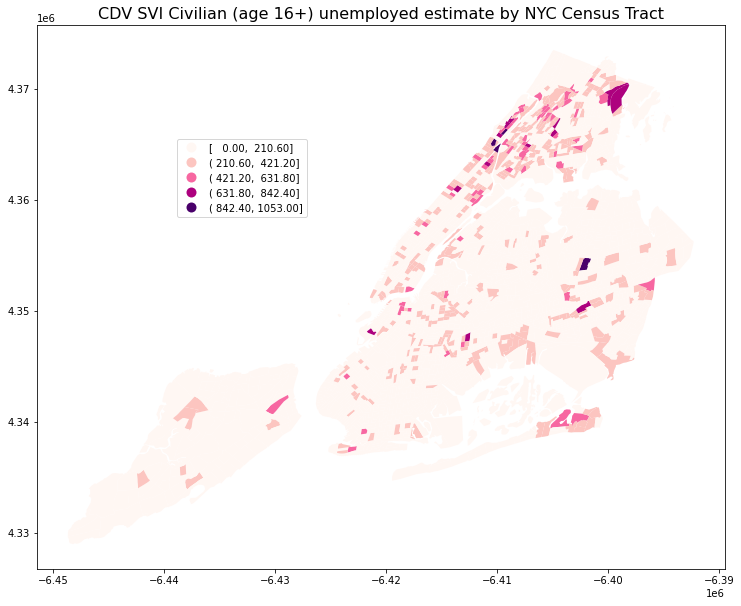

In [24]:
# plot unemployment rate variation across NYC
colors = 5
cmap = 'RdPu'
figsize = (16, 10)
ax = gdf_nyc.dropna().plot(column='E_UNEMP', cmap=cmap, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
ax.set_title('CDV SVI Civilian (age 16+) unemployed estimate by NYC Census Tract', fontdict={'fontsize': 16}, loc='center')
ax.get_legend().set_bbox_to_anchor((.40, .8))

Join Neighbourhood level SVI data to Corporate and City level CDP Response Data for NYC

e.g for the Bronx

In [25]:
del cc_df 
del svi_df
del cities_meta_df 
del cities_cdpmeta_df
del cities_6_2
del cities_count
del cc_2_4a

In [26]:
# subset for Bronx
bb_df = nyc_svi_df[(nyc_svi_df.COUNTY =='Bronx')]

# join to city and climate change response data
print(cc_nyc.shape)
cc_nyc = cc_nyc.rename(columns={'City Org' : 'City'})
nyc_df = pd.merge(cc_nyc,bb_df,on='City',how='outer')
print(nyc_df.shape)

(2465, 23)
(835635, 147)


In [27]:
nyc_df.head()

,account_number,organization,survey_year,response_received_date,accounting_period_to,ors_response_id,submission_date,page_name,module_name,question_number,...,F_CROWD,F_NOVEH,F_GROUPQ,F_THEME4,F_TOTAL,E_UNINSUR,M_UNINSUR,EP_UNINSUR,MP_UNINSUR,E_DAYPOP
0,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,0,-999,1,-999,-999,0,17,-999.0,-999.0,15770
1,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,-999,-999,-999,-999,-999,0,12,-999.0,-999.0,392
2,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,-999,-999,-999,-999,-999,0,12,-999.0,-999.0,765
3,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,-999,-999,-999,-999,-999,0,12,-999.0,-999.0,211
4,3551,Colgate Palmolive Company,2019,2019-07-31T17:54:20Z,NaN,40142,2019-09-20T12:57:12Z,C2.4a,C2. Risks and opportunities,C2.4a,...,-999,-999,-999,-999,-999,0,12,-999.0,-999.0,5077


#### Water Responses

Identify organisations with facilities oeprating in the Hudson river basin, flagging companies who's operations may impact NYC's major fresh water resource


In [28]:
ws_df_4_1c = ws_df[ws_df['question_number'] == 'W4.1c']
ws_df_4_1c = ws_df_4_1c[ws_df_4_1c['response_value'].notnull()]
ws_df_4_1c.head()         

,account_number,organization,survey_year,response_received_date,accounting_period_to,ors_response_id,submission_date,page_name,module_name,question_number,question_unique_reference,column_number,column_name,table_columns_unique_reference,row_number,row_name,data_point_name,data_point_id,response_value,comments
816,32533,"Integrated Device Technology, Inc.",2019,2019-07-30T16:38:01Z,NaN,58637,2019-09-03T17:38:31Z,W4.1c,W4. Risks and opportunities,W4.1c,"By river basin, what is the number and proport...",3.0,W4.1c_C3Number of facilities exposed to water ...,W4.1c_c3-Number of facilities exposed to water...,2,NaN,"W4.1c_C3_By river basin, what is the number an...",1335,1.0,NaN
933,32533,"Integrated Device Technology, Inc.",2019,2019-07-30T16:38:01Z,NaN,58637,2019-09-03T17:38:31Z,W4.1c,W4. Risks and opportunities,W4.1c,"By river basin, what is the number and proport...",1.0,W4.1c_C1Country/Region,W4.1c_c1-Country/Region,2,NaN,"W4.1c_C1_By river basin, what is the number an...",1333,Malaysia,NaN
940,32533,"Integrated Device Technology, Inc.",2019,2019-07-30T16:38:01Z,NaN,58637,2019-09-03T17:38:31Z,W4.1c,W4. Risks and opportunities,W4.1c,"By river basin, what is the number and proport...",8.0,W4.1c_C8% companyâ€™s total global revenue tha...,W4.1c_c8-% companyâ€™s total global revenue th...,1,NaN,"W4.1c_C8_By river basin, what is the number an...",1341,Unknown,NaN
1043,32533,"Integrated Device Technology, Inc.",2019,2019-07-30T16:38:01Z,NaN,58637,2019-09-03T17:38:31Z,W4.1c,W4. Risks and opportunities,W4.1c,"By river basin, what is the number and proport...",4.0,W4.1c_C4% company-wide facilities this represents,W4.1c_c4-% company-wide facilities this repres...,2,NaN,"W4.1c_C4_By river basin, what is the number an...",1336,Less than 1%,NaN
1091,32533,"Integrated Device Technology, Inc.",2019,2019-07-30T16:38:01Z,NaN,58637,2019-09-03T17:38:31Z,W4.1c,W4. Risks and opportunities,W4.1c,"By river basin, what is the number and proport...",4.0,W4.1c_C4% company-wide facilities this represents,W4.1c_c4-% company-wide facilities this repres...,1,NaN,"W4.1c_C4_By river basin, what is the number an...",1336,Less than 1%,NaN


Reshape data

- Climate change and water response datasets are often presented in long format in the CDP datasets.
- These data sets will become more useful when widened on the 'column_name' variable, enabling you to derive measurable metrics and KPIs from questionnaire response data

In [29]:
# pivot data
ws_df_4_1c_wide = ws_df_4_1c.pivot_table(index=['account_number', 'organization', 'row_number'],
                                     columns='column_name', 
                                     values='response_value',
                                     aggfunc=lambda x: ' '.join(x)).reset_index()
# identify orgs with facilities within the Hudson river basin
ws_df_4_1c_wide = ws_df_4_1c_wide[ws_df_4_1c_wide['W4.1c_C2River basin'].str.contains('Hudson', na=False)]
ws_df_4_1c_wide.head()

column_name,account_number,organization,row_number,W4.1c_C1Country/Region,W4.1c_C2River basin,W4.1c_C3Number of facilities exposed to water risk,W4.1c_C4% company-wide facilities this represents,W4.1c_C5Production value for the metals & mining activities associated with these facilities,W4.1c_C6% companyâ€™s annual electricity generation that could be affected by these facilities,W4.1c_C7% companyâ€™s global oil & gas production volume that could be affected by these facilities,W4.1c_C8% companyâ€™s total global revenue that could be affected,W4.1c_C9Comment
92,2982,Celgene Corporation,10,United States of America,Hudson River,5.0,1-25,NaN,NaN,NaN,Unknown,NaN
408,34390,Momentive,1,United States of America,Hudson River,1.0,1-25,NaN,NaN,NaN,1-25,NaN
460,59905,Darling Ingredients Inc,3,United States of America,Hudson River,1.0,Less than 1%,NaN,NaN,NaN,Unknown,NaN


In [30]:
ws_df.head()

,account_number,organization,survey_year,response_received_date,accounting_period_to,ors_response_id,submission_date,page_name,module_name,question_number,question_unique_reference,column_number,column_name,table_columns_unique_reference,row_number,row_name,data_point_name,data_point_id,response_value,comments
0,20111,Vander Bend,2019,2019-07-18T16:12:55Z,NaN,60218,2019-09-03T15:51:03Z,W0.2,W0. Introduction,W0.2,State the start and end date of the year for w...,1.0,W0.2_C1Start date,W0.2_c1-Start date,1,Reporting year,W0.2_C1_State the start and end date of the ye...,1262,2018-07-01,NaN
1,20111,Vander Bend,2019,2019-07-18T16:12:55Z,NaN,60218,2019-09-03T15:51:03Z,W4.2,W4. Risks and opportunities,W4.2,Provide details of identified risks in your di...,13.0,W4.2_C13Potential financial impact figure - ma...,W4.2_c13-Potential financial impact figure - m...,0,NaN,W4.2_C13_Provide details of identified risks i...,8631,NaN,NaN
2,20111,Vander Bend,2019,2019-07-18T16:12:55Z,NaN,60218,2019-09-03T15:51:03Z,W1.1,W1. Current state,W1.1,Rate the importance (current and future) of wa...,1.0,W1.1_C1Direct use importance rating,W1.1_c1-Direct use importance rating,1,Sufficient amounts of good quality freshwater ...,W1.1_C1_Rate the importance (current and futur...,1269,Neutral,NaN
3,20111,Vander Bend,2019,2019-07-18T16:12:55Z,NaN,60218,2019-09-03T15:51:03Z,W1.2,W1. Current state,W1.2,"Across all your operations, what proportion of...",1.0,W1.2_C1% of sites/facilities/operations,W1.2_c1-% of sites/facilities/operations,13,Water recycled/reused,"W1.2_C1_Across all your operations, what propo...",1273,Not relevant,NaN
4,20111,Vander Bend,2019,2019-07-18T16:12:55Z,NaN,60218,2019-09-03T15:51:03Z,W1.2h,W1. Current state,W1.2h,Provide total water withdrawal data by source.,2.0,W1.2h_C2Volume (megaliters/year),W1.2h_c2-Volume (megaliters/year),6,Third party sources,W1.2h_C2_Provide total water withdrawal data b...,1277,NaN,NaN


### Modelling

#### What next?

Suggested analysis and modelling techniques that you can be apply as you tackle the [competitions problem statement](https://www.kaggle.com/c/cdp-unlocking-climate-solutions/overview/description).

Suggestions below are **only** a guide. You are not limited to these approaches -  use your imagination and publically available data to tackle this challenge from any angle you can dream of! 


**NLP principles to investigate the social-environmental overlap between Corporations and Cities Climate Change 'Readiness'**

- Utilise pythons NLP capabilities and tokenization approaches such as [Term Frequency–inverse Document Frequency (TF-IDF)](https://medium.com/analytics-vidhya/getting-started-with-nlp-tokenization-document-term-matrix-tf-idf-2ea7d01f1942) (1) to construct a Document Term Matrix (DTM) from questionnaire responses, highlighting key terms in free text answers to aid in topic identification

        - e.g. summarise city 'readiness' for climate change and the hazards they anticipate (Cities Question 2.1)
        - e.g outline the future adaptations cities must implement to prepare for environmental challenges (City Question 3.0)
        - e.g. find common topics in examples of colloboration between cities and business on sustainability projects (City Question 6.2a)

- Apply [sentiment analysis](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6267440/) to detect whether a city sees opportunity (positive sentiment/polarity) (Cities Question 6.0) or concern (negative sentiment/polarity) (City Question 2.2) over future climate scenarios


- Combine DTM and Sentiment analysis to build a combined KPI that incorporates measures of sentiment and susceptibility into one metric, identifying cities with high levels of percieved risk who may be open to colloboration with business as they foster climate resilience.

        - e.g. Sentiment x Susceptibility  = Climate Risk Sensitivity Score



**Social Accounting with Water Shadow Price Modeling**

Using external datasets and water-related risks identified by Corporations (Water Security Question W4.2), build a 'Shadow Price' of water for Corporations operating in a selection of North American cities. 

- A [shadow price](https://www.fir-pri-awards.org/wp-content/uploads/MasterThesis_Chisem.pdf) (3) can attempt to account for the total cost of a Corporations water use, estimating all internal and external costs ,as well as exposure to water stress. 

- The shadow price coefficient can be combined within volumetric withdrawal data (Water Security Question W5.1a) to assign a Water Risk Cost per company, weighting corporate activties with a measure of the inersection between environmental risks and social impact.

    - e.g. Water risk cost for Company  = Shadow price for Company  * Water withdrawal volume for Company 



**References**

1. Muñoz (2020). Getting started with NLP: Tokenization, Document-Term Matrix, TF-IDF. Medium. https://medium.com/analytics-vidhya/getting-started-with-nlp-tokenization-document-term-matrix-tf-idf-2ea7d01f1942

2. Reyes-Menendez A, Saura JR, Alvarez-Alonso C. Understanding #WorldEnvironmentDay User Opinions in Twitter: A Topic-Based Sentiment Analysis Approach. Int J Environ Res Public Health. 2018;15(11):2537. Published 2018 Nov 13. doi:10.3390/ijerph15112537. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6267440/

3. FIR-PRI. Portfolio Analysis Using Water Shadow Pricing: How Valuing Water Risk Can Reduce Carbon Emissions. https://www.fir-pri-awards.org/wp-content/uploads/MasterThesis_Chisem.pdf

In [31]:
cities_usa = cities_df[cities_df['Country'] == 'United States of America']\
    .rename(columns={'Organization': 'City'})

In [32]:
cities_hazards = cities_usa[cities_usa['Column Name'] == 'Please describe the impacts experienced so far, and how you expect the hazard to impact in   the future']\
    .rename(columns={'Organization': 'City'})

cities_hazards['Response Answer'] = cities_hazards['Response Answer'].fillna('No Response')

In [33]:
cities_hazards = cities_hazards.assign(target=1)

In [34]:
hazards = cities_hazards[['Response Answer', 'target']]
hazards = hazards[~hazards['Response Answer'].isin(['No Response'])]
hazards.head()

,Response Answer,target
21,Flooding from sea level rise will damage build...,1
1341,A severe rainstorm can not only prove to be fa...,1
1963,"Basalt, Colorado, a town roughly 17 miles nort...",1
7558,Although Las Vegas is prepared for periods of ...,1
8704,State records identify 133 dams in Clark Count...,1


In [35]:
%matplotlib inline
# Import libraries for text manipulation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
# Import modules for evaluation purposes
# Import libraries for predcton
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

from wordcloud import WordCloud

In [36]:
X_train, X_test, y_train, y_test = train_test_split(hazards['Response Answer'], hazards['target'].values , test_size=0.20, random_state=0)
# Show the size of our datasets
print('X Train Size:',X_train.shape)
print('X Test Size:',X_test.shape)

X Train Size: (562,)
X Test Size: (141,)


In [37]:
# Create a Counter of tokens
count_vectorizer = CountVectorizer(decode_error='ignore', lowercase=True, min_df=2)
# Apply it on the train data to get the vocabulary and the mapping. This vocab and mapping is then applied to the test set.
# Before, we convert to Unicode to avoid issues with CountVectorizer
train = count_vectorizer.fit_transform(X_train.values.astype('U'))
test = count_vectorizer.transform(X_test.values.astype('U'))

In [38]:
print('Train size: ',train.shape)
print('Test size: ',test.shape)

Train size:  (562, 2572)
Test size:  (141, 2572)


In [39]:
# Extract the vocabulary as a list of (word, frequency)
vocab = list(count_vectorizer.vocabulary_.items())
print(vocab[:10])

[('impact', 1211), ('to', 2341), ('vulnerable', 2471), ('populations', 1760), ('march', 1459), ('2019', 68), ('was', 2482), ('the', 2306), ('first', 985), ('time', 2337)]


In [40]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB()
model.fit(train, y_train)
print("train score:", model.score(train, y_train))
print("test score:", model.score(test, y_test))

train score: 1.0
test score: 1.0


In [41]:
# Create the confussion matrix
def plot_confussion_matrix(y_test, y_pred):
    ''' Plot the confussion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confussion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))
    #plt.figure(figsize = (10,7))
    # Plot the confussion matrix
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(df_cm, annot=True,fmt='.0f',annot_kws={"size": 10})# font size
    plt.show()

In [42]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

              precision    recall  f1-score   support

           1    1.00000   1.00000   1.00000       141

    accuracy                        1.00000       141
   macro avg    1.00000   1.00000   1.00000       141
weighted avg    1.00000   1.00000   1.00000       141



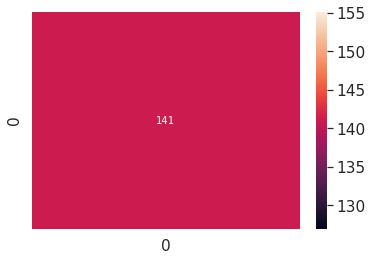

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning:

No negative samples in y_true, false positive value should be meaningless



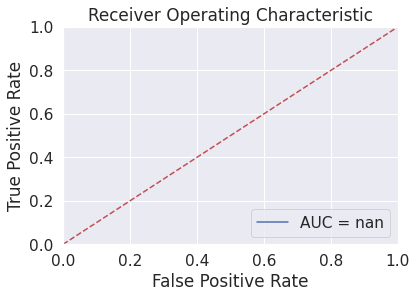

In [43]:
# Predicting the Test set results
y_pred = model.predict(test)

print(metrics.classification_report(y_test, y_pred,  digits=5))
plot_confussion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred)

In [44]:
# visualize the data on a WordCloud
def visualize(label):
  words = ''
  for msg in hazards[hazards['target'] == label]['Response Answer']:
    msg = msg.lower()
    words += msg + ' '
  wordcloud = WordCloud(width=600, height=600).generate(words)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

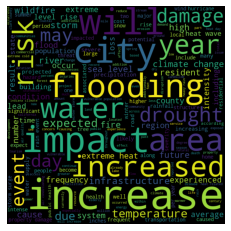

In [45]:
visualize(1)